In [2]:
from enum import Enum
from time import sleep
import pygame as pg
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pygame 2.1.2 (SDL 2.0.18, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
mazeM = [
    [2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 4, 0, 1, 0, 0, 0, 0],
    [4, 0, 0, 0, 0, 1, 4, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 4, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 4, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 4, 3]
]

In [4]:
"""
0: Way
1: Block
2: Start
3: Target
4: Flag
"""
class Maze():
    def __init__(self, maze, doDraw):
        self.WIDTH = 500
        self.maze = maze
        self.HEIGHT = 550
        self.doDraw = doDraw
        if doDraw:
            self.create_game()
        
        self.color_Way = (255,255,255)
        self.color_GR = (40,10,60)
        color_Block = (255,0,0)
        color_Start = (200,200,200)
        self.color_Black = (0,0,0)
        color_Flag = (0,160,90)
        color_Target = (200,200,0)

        self.dict_color = {0:self.color_Way, 1:color_Block, 2:color_Start, 3:color_Target, 4: color_Flag}
        self.border_width = 1
        self.cell_size = self.WIDTH/len(maze)

        self.flags = {}
        self.orderedFlags = []

        for y in range(len(maze)):
            for x in range(len(maze[y])):
                if maze[y][x] == 2:
                    self.start_pos = [y, x]
                elif maze[y][x] == 4:
                    self.flags[(y, x)] = False
                    self.orderedFlags += [(y,x)]

        self.player = Player(self)
        self.steps = 0

    def create_game(self):
        pg.init()
        self.font = pg.font.Font('FreeSansBold.ttf', 32)
        self.screen = pg.display.set_mode((self.WIDTH, self.HEIGHT))
        pg.display.set_caption("MAZE RL")
        
    def reset(self):
        self.player.reset(self)
        self.steps = 0
        self.watched = {self.player.player_pos}
        for x in self.flags.keys():
            self.flags[x] = False

    def capture_flag(self, y, x):
        if self.maze[y][x] == 4 and self.flags[(y,x)] == False:
            self.flags[(y,x)] = True
            return True
        return False

    def draw(self):
        self.screen.fill(self.color_Black)
        for y in range(len(self.maze)):
            for x in range(len(self.maze[y])):
                pg.draw.rect(self.screen, self.color_GR, (x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size), self.border_width)
                
                if self.maze[y][x] != 4 or self.flags[(y,x)] == False:
                        color = self.dict_color[self.maze[y][x]]
                else:
                    color = self.dict_color[0]

                pg.draw.rect(self.screen, color, (x * self.cell_size + self.border_width, y * self.cell_size + self.border_width, self.cell_size - 2 * self.border_width, self.cell_size - 2 * self.border_width))
        self.player.draw(self)
        self.text_render()
        pg.display.update()

    def text_render(self):
        text = self.font.render("Steps: {}".format(self.steps), True, self.color_Way)
        textRect = text.get_rect()
        textRect.center = 100 , 520
        self.screen.blit(text, textRect)

    def check_visited(self, y, x):
        flag = False
        if (y,x) in self.watched:
            flag = True
        else:
            self.watched.add((y,x))
        return flag

    def move(self, action):
        y,x = self.player.move(action, True)
        self.steps += 1
        if self.check_visited(y, x):
            return -10, False
        if self.capture_flag(y,x):
            return 50, False
        if self.maze[y][x] == 3:
            if False in self.flags.values():
                return -400, True
            return 100, True
        return -1, False

    def get_flags(self, only_count):
        if only_count:
            flags_count = 0
            for value in self.flags.values():
                if value:
                    flags_count += 1
            return flags_count
        return tuple([self.flags[(y, x)] for y, x in self.orderedFlags])

    def check_cell_valid(self, y, x):
        return not(y < 0 or x < 0 or y >= len(self.maze) or x >= len(self.maze[0]) or self.maze[y][x] == 1)

class Player():
    def __init__(self, maze):
        self.reset(maze)
        self.color = (100,50,100)
        self.radius = maze.cell_size * .4

    def reset(self, maze):
        self.player_pos = maze.start_pos[0], maze.start_pos[1]

    def draw(self, maze):
        y, x = (self.player_pos[0] + .5) * maze.cell_size, (self.player_pos[1] + .5) * maze.cell_size
        pg.draw.circle(maze.screen, self.color, (x, y), self.radius)

    def check_move_valid(self, maze, action):
        y, x = self.move(action)
        return maze.check_cell_valid(y, x)

    def move(self, action, assign=False):
        y, x = self.player_pos[0], self.player_pos[1]
        if action == Action.Up:
            y -= 1
        elif action == Action.Down:
            y += 1
        elif action == Action.Right:
            x += 1
        else:
            x -= 1
        if assign:
            self.player_pos = y, x
        return y, x

class Action(Enum):
    Up = 0
    Right = 1
    Down = 2
    Left = 3
    Default = 6

class RL():
    def __init__(self, maze, times, gamma= .9, alpha= .1, epsilon= .1, only_count=False):
        self.maze = maze
        self.player = maze.player
        self.actions = [Action.Up, Action.Right, Action.Down, Action.Left]
        self.times = times
        self.gamma = gamma
        self.Qs = {}
        self.alpha = alpha
        self.epsilon = epsilon 
        self.only_count = only_count

    def choose(self, state, playing= False):
        possible_actions = self.get_possible_actions()
        if not playing and random.random() < self.epsilon:
            return random.choice(possible_actions)
        Qs = [self.getQ(state, a) for a in possible_actions]
        maxQ = max(Qs)
        bigest = random.choice([a for i, a in enumerate(possible_actions) if Qs[i] == maxQ])  
        return bigest

    def get_possible_actions(self):
        return [action for action in self.actions if self.player.check_move_valid(maze, action)]

    def getQ(self, state, action):
        if (state, action) in self.Qs:
            return self.Qs[(state, action)]
        return 0

    def updateQ(self, state, action, reward, next_state):   
        Q = self.getQ(state, action)
        maxQnext = 0
        possible_moves = self.get_possible_actions()
        for a in possible_moves:
            maxQnext = max(self.getQ(next_state, a), maxQnext)
        if len(possible_moves):
            Q = Q + self.alpha * (reward + self.gamma * maxQnext - Q)
        else :
            Q += reward
        self.Qs[(state, action)] = Q 
        return Q

    def get_state(self):
        return self.player.player_pos[0], self.player.player_pos[1], self.maze.get_flags(self.only_count)

    def start(self):
        self.steps = np.zeros(self.times)
        self.costs = np.zeros(self.times)
        for episode in range(self.times):
            step, cost = self.play(self.maze.doDraw)
            print("Done {0}| Steps: {1} with Costs: {2}".format(episode, step, cost))
            self.costs[episode] = cost
            self.steps[episode] = self.maze.steps
        print("The average of the last 5: ",np.average(self.steps[-5:]))
    
    def print_Qs_Nan(self):
        data = [(k[0], k[1].name, v) for k, v in rl.Qs.items()]
        df = pd.DataFrame.from_records(data, columns=['State', 'Action', 'Value'])
        df.set_index(['State', 'Action'], inplace=True)
        df = df.unstack()
        df.columns = df.columns.get_level_values(1)
        df.reset_index(inplace=True)
        df.index.name = None
        pd.set_option('display.max_rows', df.shape[0])
        return df
    
    def print_Qs(self):
        df = self.print_Qs_Nan()
        df.fillna(0, inplace=True)
        return df

    def plt_steps(self):
        plt.figure()
        plt.plot(np.arange(len(self.steps)), self.steps, 'b')
        plt.title('Episode via steps')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
    
    def plt_costs(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs, 'b')
        plt.title('Episode via costs')
        plt.xlabel('Episode')
        plt.ylabel('Costs')

    def plt_costs_av_steps(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs/self.steps, 'b')
        plt.title('Episode via average costs over steps')
        plt.xlabel('Episode')
        plt.ylabel('average costs over steps')

    def play(self, doDraw=True, playing=False):
        cost = 0
        self.maze.reset()
        state = self.get_state()
        if playing and doDraw:
            self.maze.create_game()
            sleep(5)
        while self.maze.steps < 3000:
            if doDraw and playing:
                for event in pg.event.get():
                    if event.type == pg.QUIT:
                        return
                maze.draw()
                if playing:
                    sleep(.2)
            action = self.choose(state, playing)
            reward, target = maze.move(action)
            next_state = self.get_state()
            cost += self.updateQ(state, action, reward, next_state)
            state = next_state
            if target:
                if doDraw:
                    maze.draw()
                    sleep(1)
                    if playing:
                        pg.quit()
                return self.maze.steps, cost 
        if playing and doDraw:
            pg.quit()
        return self.play(doDraw, playing)

# Part 1
## (gamma = .9 , alpha = .1)

In [35]:
doDraw, times, gamma, alpha = False, 500, .9, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 360 with Costs: -364.0500000000004
Done 1| Steps: 614 with Costs: -1123.1276400000002
Done 2| Steps: 1152 with Costs: -4366.33009178859
Done 3| Steps: 344 with Costs: -1015.450831476001
Done 4| Steps: 258 with Costs: -577.2968828426197
Done 5| Steps: 462 with Costs: -911.6074206297335
Done 6| Steps: 136 with Costs: -316.2801626662299
Done 7| Steps: 78 with Costs: 11.626788339476384
Done 8| Steps: 72 with Costs: 62.68768820198766
Done 9| Steps: 60 with Costs: 159.06370778412943
Done 10| Steps: 62 with Costs: 176.34469906740574
Done 11| Steps: 52 with Costs: 282.95537691253264
Done 12| Steps: 52 with Costs: 349.1363328067472
Done 13| Steps: 138 with Costs: -206.65580323115745
Done 14| Steps: 68 with Costs: 271.08933241088573
Done 15| Steps: 80 with Costs: 253.3305717230187
Done 16| Steps: 66 with Costs: 333.4257746508189
Done 17| Steps: 52 with Costs: 515.9010653276237
Done 18| Steps: 64 with Costs: 346.1864340167349
Done 19| Steps: 74 with Costs: 344.2829529351957
Done 20

Done 233| Steps: 56 with Costs: 2824.9414908213403
Done 234| Steps: 54 with Costs: 2751.3927769910833
Done 235| Steps: 54 with Costs: 2844.77622404179
Done 236| Steps: 52 with Costs: 2634.964536546895
Done 237| Steps: 48 with Costs: 2565.9529657115277
Done 238| Steps: 56 with Costs: 2613.4253318514284
Done 239| Steps: 44 with Costs: 2480.291068010726
Done 240| Steps: 48 with Costs: 2468.0674434716975
Done 241| Steps: 54 with Costs: 2821.1309291134776
Done 242| Steps: 52 with Costs: 2640.2090182082497
Done 243| Steps: 46 with Costs: 2600.744478300326
Done 244| Steps: 46 with Costs: 2496.841987480551
Done 245| Steps: 48 with Costs: 2470.5318132723555
Done 246| Steps: 50 with Costs: 2690.515127858613
Done 247| Steps: 52 with Costs: 2747.8335167037753
Done 248| Steps: 44 with Costs: 2494.1045368807654
Done 249| Steps: 48 with Costs: 2605.046101139508
Done 250| Steps: 56 with Costs: 2619.3357282929264
Done 251| Steps: 54 with Costs: 2616.9535325132265
Done 252| Steps: 56 with Costs: 3194.62

In [36]:
rl.print_Qs()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",84.817673,0.000000,0.000000,0.000000
1,"(0, 0, (False, True, False, False, False, False))",-2.710000,0.000000,0.000000,0.000000
2,"(0, 0, (True, True, False, False, False, False))",-5.217031,0.000000,0.000000,0.000000
3,"(0, 0, (True, True, True, False, False, False))",-3.439000,0.000000,0.000000,0.000000
4,"(0, 0, (True, True, True, True, False, False))",-7.941089,0.000000,0.000000,0.000000
5,"(0, 0, (True, True, True, True, True, False))",-6.513216,0.000000,0.000000,0.000000
6,"(0, 2, (False, False, False, False, False, Fal...",-1.000000,0.000000,0.000000,0.000000
7,"(0, 2, (False, True, False, False, False, False))",40.064231,0.000000,5.705582,0.000000
8,"(0, 2, (True, False, False, False, False, False))",-1.000000,0.000000,-0.100000,0.000000
9,"(0, 2, (True, False, True, True, False, False))",-1.900000,0.000000,-1.000000,0.000000


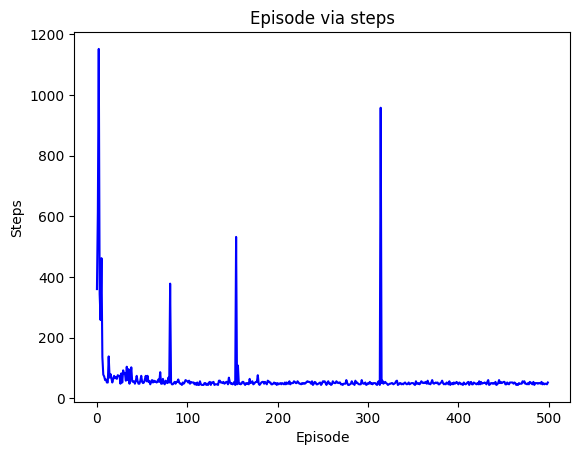

In [37]:
rl.plt_steps()

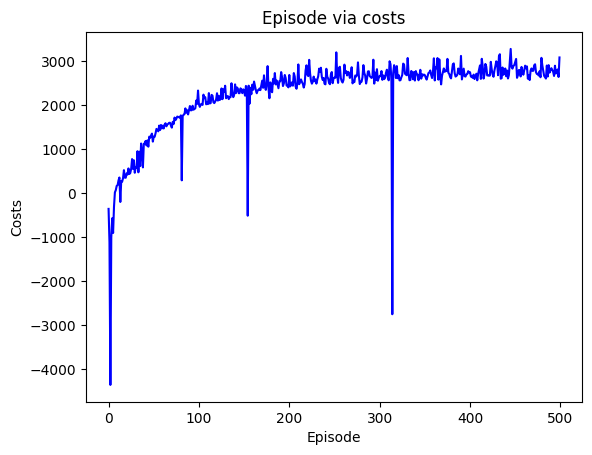

In [38]:
rl.plt_costs()

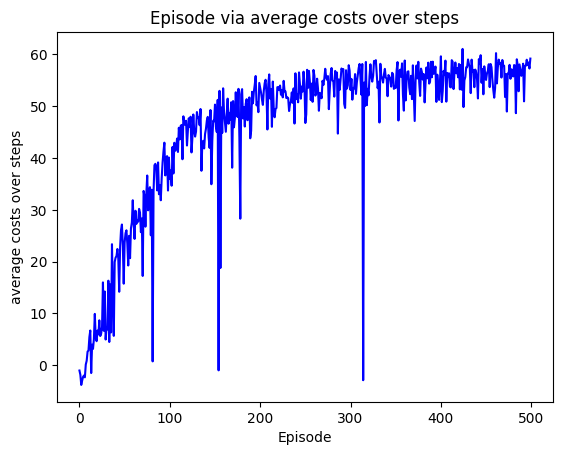

In [39]:
rl.plt_costs_av_steps()

In [245]:
rl.play(True, True)

(44, 2601.8491667560884)

In [40]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",84.817673,NaN,NaN,NaN
1,"(0, 0, (False, True, False, False, False, False))",-2.710000,NaN,NaN,NaN
2,"(0, 0, (True, True, False, False, False, False))",-5.217031,NaN,NaN,NaN
3,"(0, 0, (True, True, True, False, False, False))",-3.439000,NaN,NaN,NaN
4,"(0, 0, (True, True, True, True, False, False))",-7.941089,NaN,NaN,NaN
5,"(0, 0, (True, True, True, True, True, False))",-6.513216,NaN,NaN,NaN
6,"(0, 2, (False, False, False, False, False, Fal...",-1.000000,NaN,NaN,NaN
7,"(0, 2, (False, True, False, False, False, False))",40.064231,NaN,5.705582,NaN
8,"(0, 2, (True, False, False, False, False, False))",-1.000000,NaN,-0.100000,NaN
9,"(0, 2, (True, False, True, True, False, False))",-1.900000,NaN,-1.000000,NaN


# Part 2
### (only_count)
Now we activate only_count. With this method, only the number of remaining flags is stored in the state. As it is known, this work has the same result as the previous state, only the number of valid states has decreased.

But again, in the case where only the agent plays and the search is stopped by eliminating epsilon, we will see the best result.

In [225]:
doDraw, times, gamma, alpha = False, 500, .9, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha, only_count=True)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 238 with Costs: -227.07999999999998
Done 1| Steps: 552 with Costs: -710.4969999999986
Done 2| Steps: 308 with Costs: -576.2421440999998
Done 3| Steps: 838 with Costs: -2186.6283410433716
Done 4| Steps: 454 with Costs: -1578.1946380228692
Done 5| Steps: 1044 with Costs: -3251.9171056920723
Done 6| Steps: 1226 with Costs: -7000.146351227229
Done 7| Steps: 90 with Costs: -187.8568597958586
Done 8| Steps: 672 with Costs: -4735.51831767516
Done 9| Steps: 62 with Costs: 94.93046998750356
Done 10| Steps: 56 with Costs: 182.88773955855032
Done 11| Steps: 70 with Costs: 65.97467459214369
Done 12| Steps: 66 with Costs: 190.27880281094974
Done 13| Steps: 78 with Costs: 123.9158786532805
Done 14| Steps: 66 with Costs: 194.0168681357997
Done 15| Steps: 58 with Costs: 288.15630697020924
Done 16| Steps: 1680 with Costs: -14291.192991539247
Done 17| Steps: 92 with Costs: 99.94813582109559
Done 18| Steps: 50 with Costs: 520.7067791710728
Done 19| Steps: 64 with Costs: 461.47427992879494


Done 451| Steps: 50 with Costs: 2836.9144454401658
Done 452| Steps: 46 with Costs: 2507.463866176202
Done 453| Steps: 50 with Costs: 2687.3603951389164
Done 454| Steps: 48 with Costs: 2596.8468142305014
Done 455| Steps: 46 with Costs: 2659.9274196954134
Done 456| Steps: 48 with Costs: 2587.6289263903595
Done 457| Steps: 50 with Costs: 2529.556590710577
Done 458| Steps: 52 with Costs: 2824.1230310885944
Done 459| Steps: 56 with Costs: 2834.9422024760993
Done 460| Steps: 56 with Costs: 2769.5546645581394
Done 461| Steps: 50 with Costs: 2763.5294773480377
Done 462| Steps: 52 with Costs: 2893.0841228371073
Done 463| Steps: 46 with Costs: 2600.873223277917
Done 464| Steps: 50 with Costs: 2717.2178815227867
Done 465| Steps: 54 with Costs: 2647.2005291624123
Done 466| Steps: 52 with Costs: 2564.7223992552317
Done 467| Steps: 50 with Costs: 2799.114928711866
Done 468| Steps: 50 with Costs: 2678.809235517706
Done 469| Steps: 48 with Costs: 2645.4160766088453
Done 470| Steps: 46 with Costs: 2552

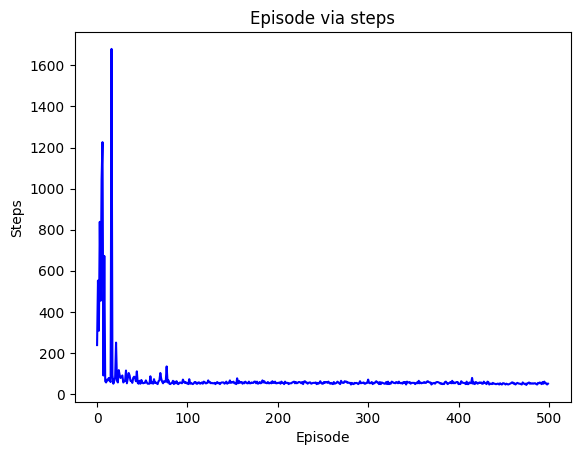

In [227]:
rl.plt_steps()

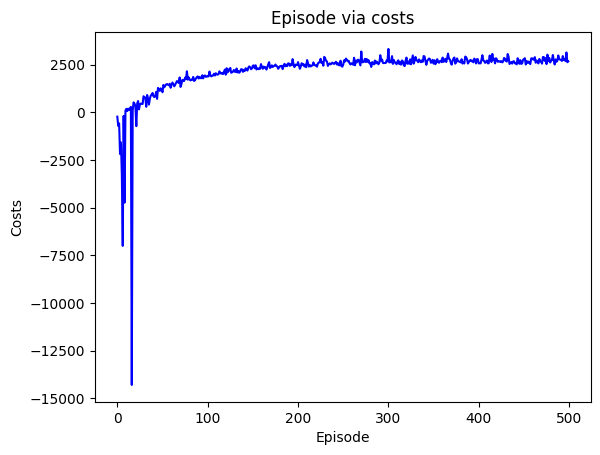

In [228]:
rl.plt_costs()

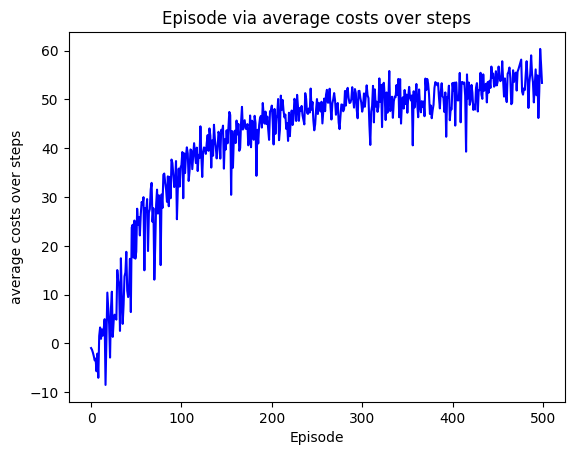

In [229]:
rl.plt_costs_av_steps()

In [226]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, 0)",84.018610,NaN,NaN,NaN
1,"(0, 0, 1)",-2.710000,NaN,NaN,NaN
2,"(0, 0, 2)",-6.125795,NaN,NaN,NaN
3,"(0, 0, 3)",-6.861894,NaN,NaN,NaN
4,"(0, 0, 5)",-9.797244,NaN,NaN,NaN
5,"(0, 2, 1)",-1.900000,NaN,-1.188783,NaN
6,"(0, 2, 2)",10.883053,NaN,27.324975,NaN
7,"(0, 2, 3)",-6.164537,NaN,-6.513216,NaN
8,"(0, 2, 4)",-1.900000,NaN,-2.710000,NaN
9,"(0, 2, 5)",-9.690968,NaN,-9.690968,NaN


In [230]:
rl.play(True, True)

(44, 2552.5768610527157)

# Part 3
### ( gamma = 0.25) (only_count = False)
As it is clear, with the decrease of gamma compared to the previous tests, the average number of steps has increased significantly in training. Also, if we don't consider epsilon, because decreasing gamma means that the future q doesn't have much effect on our choice, we might get stuck in a loop like the play executed below. So it is not a good idea to use this gamma.

It is also clear that one of the reasons was the increase in the number of cases due to this change.

In [5]:
doDraw, times, gamma, alpha = False, 500, .25, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 398 with Costs: -411.9750000000001
Done 1| Steps: 2182 with Costs: -8108.829049629852
Done 2| Steps: 320 with Costs: -1275.473988285681
Done 3| Steps: 248 with Costs: -1081.9931576219017
Done 4| Steps: 78 with Costs: -108.10061523817642
Done 5| Steps: 62 with Costs: -17.700373155699943
Done 6| Steps: 82 with Costs: -15.521735715995838
Done 7| Steps: 384 with Costs: -817.9487454161152
Done 8| Steps: 98 with Costs: -114.19305769122653
Done 9| Steps: 112 with Costs: -169.9202527774121
Done 10| Steps: 86 with Costs: -22.905061675427277
Done 11| Steps: 84 with Costs: -9.187548814958916
Done 12| Steps: 88 with Costs: -24.2889874002192
Done 13| Steps: 86 with Costs: -35.51623337743962
Done 14| Steps: 56 with Costs: 210.63234137542293
Done 15| Steps: 58 with Costs: 188.3913452271678
Done 16| Steps: 90 with Costs: 25.748833583627956
Done 17| Steps: 298 with Costs: -537.4489418827877
Done 18| Steps: 48 with Costs: 297.5976571535814
Done 19| Steps: 76 with Costs: 91.71257351299195


Done 212| Steps: 72 with Costs: 268.19689301084077
Done 213| Steps: 198 with Costs: -984.3341624664461
Done 214| Steps: 60 with Costs: 400.5597828675131
Done 215| Steps: 146 with Costs: -469.85835769133735
Done 216| Steps: 70 with Costs: 270.9401709904056
Done 217| Steps: 64 with Costs: 321.96431206369175
Done 218| Steps: 92 with Costs: 44.43990228255488
Done 219| Steps: 58 with Costs: 384.822987254244
Done 220| Steps: 242 with Costs: -1398.1053492592275
Done 221| Steps: 62 with Costs: 343.82361562355754
Done 222| Steps: 76 with Costs: 245.62581381257192
Done 223| Steps: 158 with Costs: -637.8415479901489
Done 224| Steps: 70 with Costs: 283.1276089601362
Done 225| Steps: 72 with Costs: 264.66058349998957
Done 226| Steps: 86 with Costs: 144.90909495397048
Done 227| Steps: 98 with Costs: 9.843113484411475
Done 228| Steps: 84 with Costs: 133.8653373312328
Done 229| Steps: 58 with Costs: 408.6245495666252
Done 230| Steps: 66 with Costs: 361.0844923249791
Done 231| Steps: 72 with Costs: 312

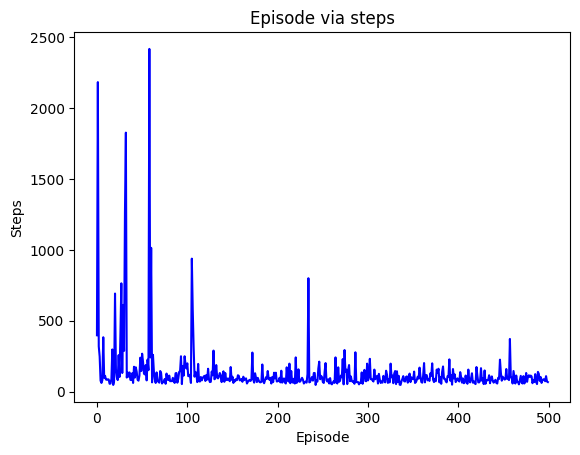

In [6]:
rl.plt_steps()

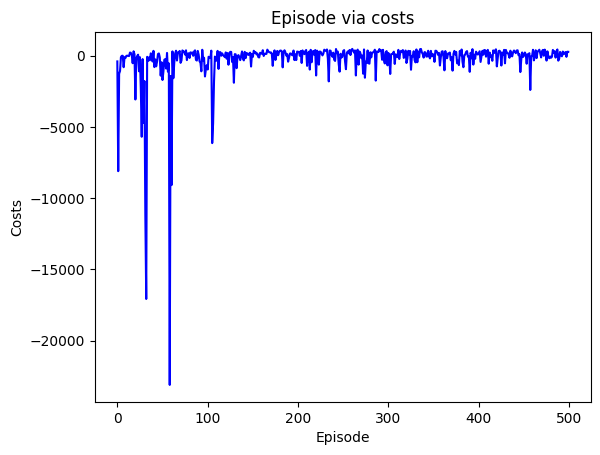

In [7]:
rl.plt_costs()

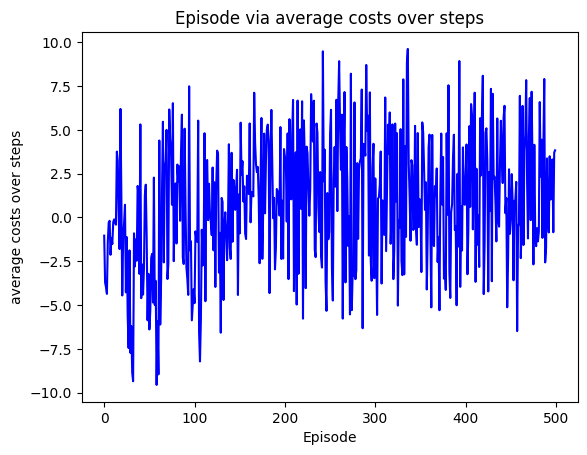

In [8]:
rl.plt_costs_av_steps()

In [9]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",11.499508,NaN,NaN,NaN
1,"(0, 0, (False, True, False, False, False, False))",-4.685590,NaN,NaN,NaN
2,"(0, 0, (True, True, False, False, False, False))",-9.966186,NaN,NaN,NaN
3,"(0, 0, (True, True, True, False, False, False))",-9.353892,NaN,NaN,NaN
4,"(0, 0, (True, True, True, True, False, False))",-10.000000,NaN,NaN,NaN
5,"(0, 0, (True, True, True, True, True, False))",-7.941089,NaN,NaN,NaN
6,"(0, 0, (True, True, True, True, True, True))",-7.941089,NaN,NaN,NaN
7,"(0, 2, (False, False, False, False, False, Fal...",-1.000000,NaN,-0.100000,NaN
8,"(0, 2, (False, True, False, False, False, False))",-0.650000,NaN,2.736975,NaN
9,"(0, 2, (True, True, False, False, False, False))",-9.934565,NaN,-9.929303,NaN


In [10]:
rl.play(True, True)

# Part 3
### ( gamma = 0.25) (only_count = True)

As it is clear, like the previous test, we are stuck in a loop here in play. Of course, it is clear that a favorable result can probably be achieved by changing the rewards.

It should be noted that both in the previous test and here, the graph of the average cost on the number of steps (how much cost (profit) we had in each step) was very fluctuating and not at all like the previous part.

It should be noted that even this low gamma affects training and has increased the average number of required steps.

So even with this change, this gamma is not suitable unless the rewards change.

In [7]:
doDraw, times, gamma, alpha = False, 500, .25, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha, only_count=True)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 568 with Costs: -637.7758999999988
Done 1| Steps: 572 with Costs: -1043.910286499999
Done 2| Steps: 968 with Costs: -3160.0362624010154
Done 3| Steps: 500 with Costs: -2268.794472354402
Done 4| Steps: 260 with Costs: -649.2901818245003
Done 5| Steps: 898 with Costs: -5431.354256709759
Done 6| Steps: 442 with Costs: -2754.44539100751
Done 7| Steps: 86 with Costs: -34.98887121832071
Done 8| Steps: 356 with Costs: -577.6438531586464
Done 9| Steps: 174 with Costs: -584.6450547885172
Done 10| Steps: 64 with Costs: -6.630693497038614
Done 11| Steps: 70 with Costs: -33.85222968863796
Done 12| Steps: 50 with Costs: 121.9646042065186
Done 13| Steps: 74 with Costs: 1.3274998968798002
Done 14| Steps: 66 with Costs: 50.413568030260286
Done 15| Steps: 82 with Costs: 15.475757824046596
Done 16| Steps: 60 with Costs: 110.41282785210076
Done 17| Steps: 68 with Costs: -127.43912859047838
Done 18| Steps: 48 with Costs: 234.40363536511967
Done 19| Steps: 92 with Costs: -35.40072595151848
D

Done 231| Steps: 52 with Costs: 408.1172175446875
Done 232| Steps: 80 with Costs: 171.68951916707306
Done 233| Steps: 94 with Costs: 89.20866601606431
Done 234| Steps: 158 with Costs: -617.6817467200043
Done 235| Steps: 58 with Costs: 364.0795679619739
Done 236| Steps: 68 with Costs: 286.24199149522195
Done 237| Steps: 70 with Costs: 289.3427754616662
Done 238| Steps: 112 with Costs: -193.3369065893944
Done 239| Steps: 118 with Costs: -220.42313345271958
Done 240| Steps: 164 with Costs: -729.8578272762713
Done 241| Steps: 96 with Costs: -13.448059744832406
Done 242| Steps: 72 with Costs: 260.67458609897096
Done 243| Steps: 104 with Costs: -99.70469566877773
Done 244| Steps: 90 with Costs: 127.16127459505671
Done 245| Steps: 86 with Costs: 169.47705189680295
Done 246| Steps: 60 with Costs: 386.2973467808335
Done 247| Steps: 196 with Costs: -1006.9483581986817
Done 248| Steps: 140 with Costs: -371.3888932720671
Done 249| Steps: 128 with Costs: -319.30752921855355
Done 250| Steps: 94 with

Done 470| Steps: 76 with Costs: 171.59744680512185
Done 471| Steps: 92 with Costs: 19.306322386642577
Done 472| Steps: 56 with Costs: 361.03585700574695
Done 473| Steps: 118 with Costs: -221.5636707771364
Done 474| Steps: 50 with Costs: 418.69042657114613
Done 475| Steps: 56 with Costs: 390.5376363374368
Done 476| Steps: 68 with Costs: 256.6788035380201
Done 477| Steps: 158 with Costs: -607.0866723281063
Done 478| Steps: 88 with Costs: 86.91344278499474
Done 479| Steps: 60 with Costs: 304.83387815918536
Done 480| Steps: 116 with Costs: -219.44965395378415
Done 481| Steps: 72 with Costs: 235.72185804358068
Done 482| Steps: 60 with Costs: 323.10064101670804
Done 483| Steps: 100 with Costs: -82.76812047026425
Done 484| Steps: 62 with Costs: 324.73213102983686
Done 485| Steps: 52 with Costs: 417.44193217153867
Done 486| Steps: 64 with Costs: 296.25983017487954
Done 487| Steps: 240 with Costs: -1468.8634916250394
Done 488| Steps: 82 with Costs: 145.28802432322368
Done 489| Steps: 62 with Co

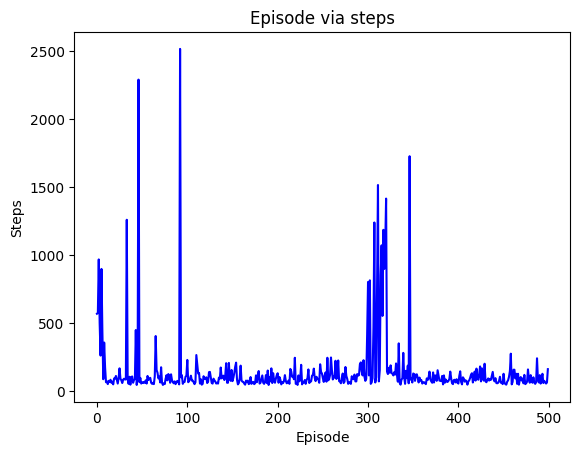

In [8]:
rl.plt_steps()

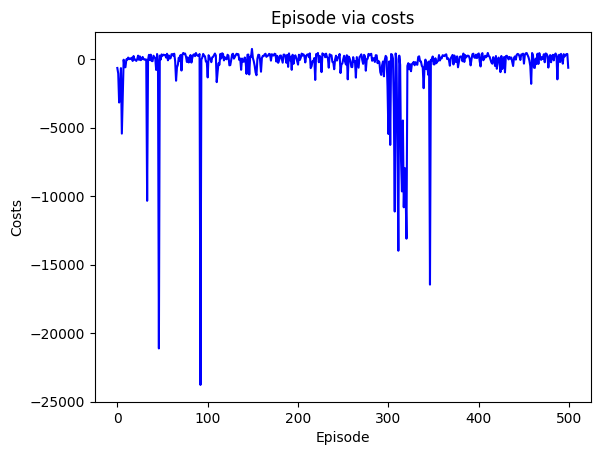

In [9]:
rl.plt_costs()

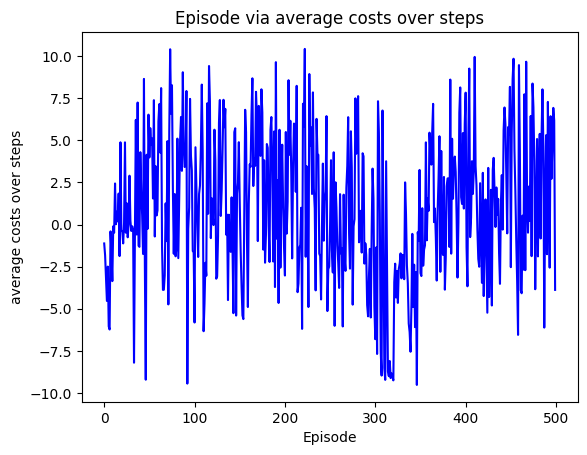

In [10]:
rl.plt_costs_av_steps()

In [11]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, 0)",10.770000,NaN,NaN,NaN
1,"(0, 0, 1)",-4.685590,NaN,NaN,NaN
2,"(0, 0, 2)",-8.146980,NaN,NaN,NaN
3,"(0, 0, 3)",-6.125795,NaN,NaN,NaN
4,"(0, 0, 4)",-10.000000,NaN,NaN,NaN
5,"(0, 0, 5)",-10.000000,NaN,NaN,NaN
6,"(0, 2, 0)",-1.000000,NaN,NaN,NaN
7,"(0, 2, 1)",1.777400,NaN,-1.090000,NaN
8,"(0, 2, 2)",-7.941089,NaN,-4.158842,NaN
9,"(0, 2, 3)",-6.513216,NaN,-6.513216,NaN


In [ ]:
rl.play(True, True)

# Part 4
## (gamma = 0.5)
As it is known, the graph of the average value per step has a strong fluctuation compared to the first and second tests, and gamma still has a small value, which has caused an increase in the number of states and, as a result, an increase in the number of steps.

In [28]:
doDraw, times, gamma, alpha = False, 500, .5, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 458 with Costs: -443.4899999999991
Done 1| Steps: 394 with Costs: -661.1357
Done 2| Steps: 490 with Costs: -957.9143269999995
Done 3| Steps: 308 with Costs: -920.3880360220005
Done 4| Steps: 102 with Costs: -244.44254090191006
Done 5| Steps: 66 with Costs: -149.4640726801
Done 6| Steps: 1608 with Costs: -5052.1451448628295
Done 7| Steps: 224 with Costs: -1152.7624303706843
Done 8| Steps: 752 with Costs: -2268.316711140188
Done 9| Steps: 582 with Costs: -2047.3858303990257
Done 10| Steps: 80 with Costs: -216.67092051708102
Done 11| Steps: 64 with Costs: -132.17730625793627
Done 12| Steps: 68 with Costs: -154.4738500577064
Done 13| Steps: 574 with Costs: -1745.1055732551065
Done 14| Steps: 536 with Costs: -2385.9954343740724
Done 15| Steps: 78 with Costs: -1.8201231896547014
Done 16| Steps: 64 with Costs: 160.54657216720375
Done 17| Steps: 682 with Costs: -4328.28882300333
Done 18| Steps: 62 with Costs: 148.91653228165444
Done 19| Steps: 592 with Costs: -4207.429043959491


Done 283| Steps: 66 with Costs: 506.1277032035547
Done 284| Steps: 78 with Costs: 366.4278365996891
Done 285| Steps: 150 with Costs: -297.73043359003304
Done 286| Steps: 66 with Costs: 475.9732445553531
Done 287| Steps: 92 with Costs: 208.03706767447505
Done 288| Steps: 88 with Costs: 286.80978063312125
Done 289| Steps: 58 with Costs: 617.067929473812
Done 290| Steps: 90 with Costs: 289.5523698302263
Done 291| Steps: 146 with Costs: -228.42466364640478
Done 292| Steps: 118 with Costs: 3.194871039773247
Done 293| Steps: 74 with Costs: 589.974031686314
Done 294| Steps: 54 with Costs: 626.4255470289215
Done 295| Steps: 134 with Costs: -179.52651767386777
Done 296| Steps: 76 with Costs: 407.4449693422828
Done 297| Steps: 222 with Costs: -1089.8726599236716
Done 298| Steps: 70 with Costs: 522.3686769750933
Done 299| Steps: 78 with Costs: 484.71302977267646
Done 300| Steps: 52 with Costs: 679.2195145361015
Done 301| Steps: 56 with Costs: 682.7930015069105
Done 302| Steps: 46 with Costs: 673.

Done 479| Steps: 206 with Costs: -950.5018270267344
Done 480| Steps: 110 with Costs: 29.917326068274775
Done 481| Steps: 58 with Costs: 558.2668942944695
Done 482| Steps: 62 with Costs: 573.3536729144885
Done 483| Steps: 78 with Costs: 365.017702236069
Done 484| Steps: 192 with Costs: -793.2353805748
Done 485| Steps: 74 with Costs: 479.84594870815835
Done 486| Steps: 96 with Costs: 321.19471158734893
Done 487| Steps: 124 with Costs: -48.63965577790344
Done 488| Steps: 50 with Costs: 683.0434330206758
Done 489| Steps: 236 with Costs: -1089.9030810115541
Done 490| Steps: 62 with Costs: 618.2832068263756
Done 491| Steps: 68 with Costs: 507.3297714756242
Done 492| Steps: 74 with Costs: 501.8365896682646
Done 493| Steps: 64 with Costs: 494.8736849245458
Done 494| Steps: 68 with Costs: 476.67319666434054
Done 495| Steps: 132 with Costs: -168.95969876143062
Done 496| Steps: 54 with Costs: 658.6799804306479
Done 497| Steps: 70 with Costs: 475.73598321044216
Done 498| Steps: 84 with Costs: 301.

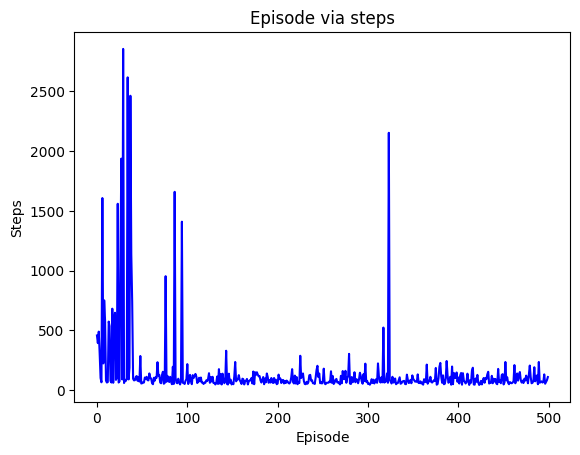

In [29]:
rl.plt_steps()

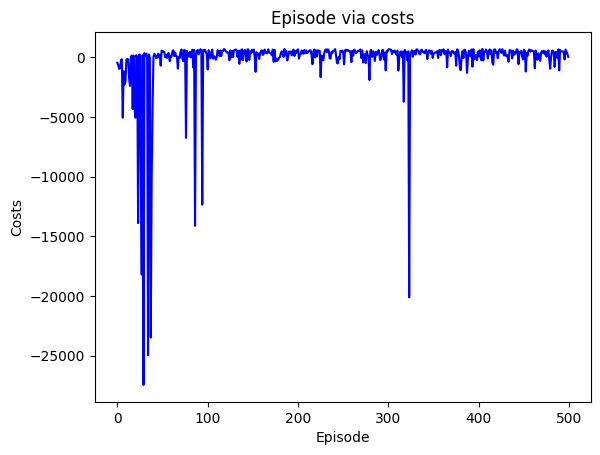

In [30]:
rl.plt_costs()

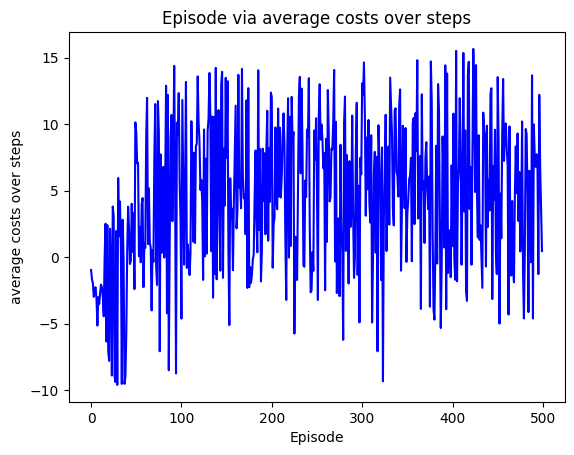

In [31]:
rl.plt_costs_av_steps()

In [32]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",24.574463,NaN,NaN,NaN
1,"(0, 0, (False, True, False, False, False, False))",-2.710000,NaN,NaN,NaN
2,"(0, 0, (True, True, False, False, False, False))",-5.217031,NaN,NaN,NaN
3,"(0, 0, (True, True, True, False, False, False))",-8.499054,NaN,NaN,NaN
4,"(0, 0, (True, True, True, True, False, False))",-10.000000,NaN,NaN,NaN
5,"(0, 0, (True, True, True, True, True, False))",-10.000000,NaN,NaN,NaN
6,"(0, 0, (True, True, True, True, True, True))",-5.217031,NaN,NaN,NaN
7,"(0, 2, (False, False, False, False, False, Fal...",NaN,NaN,-1.090000,NaN
8,"(0, 2, (False, True, False, False, False, False))",11.911062,NaN,-0.100000,NaN
9,"(0, 2, (True, False, False, False, False, False))",NaN,NaN,-1.000000,NaN


In [ ]:
rl.play(True, True)

# Part 5
## (gamma = 1) (alpha = 0.1)
As it is clear, like our first test (gamma equal to 0.9), the result is reasonable and even the graph of the average value on the steps is not like the bad tests and does not fluctuate, and also in the case without epsilon, it goes the best way.

Of course, this test will gain more value (cost) along the way than the first and second tests.

So our conclusion is correct and by increasing gamma (not too low gamma) we can get a reasonable result.

In [46]:
doDraw, times, gamma, alpha = False, 500, 1, .1
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 364 with Costs: -428.96979999999894
Done 1| Steps: 332 with Costs: -397.5647000000003
Done 2| Steps: 528 with Costs: -772.0329989999993
Done 3| Steps: 1262 with Costs: -4442.5143709458125
Done 4| Steps: 176 with Costs: -376.47198041799993
Done 5| Steps: 134 with Costs: -258.24595075124097
Done 6| Steps: 150 with Costs: -343.9683652260289
Done 7| Steps: 158 with Costs: -301.816547849041
Done 8| Steps: 164 with Costs: -355.24236393676347
Done 9| Steps: 286 with Costs: -735.9856124121857
Done 10| Steps: 76 with Costs: 147.62592382771828
Done 11| Steps: 62 with Costs: 201.25744241335624
Done 12| Steps: 66 with Costs: 252.1053490026245
Done 13| Steps: 68 with Costs: 247.66316454169043
Done 14| Steps: 310 with Costs: -680.8485317352114
Done 15| Steps: 96 with Costs: 230.52275096615693
Done 16| Steps: 82 with Costs: 293.0188006320858
Done 17| Steps: 92 with Costs: 265.36011920740077
Done 18| Steps: 78 with Costs: 375.0347452984135
Done 19| Steps: 560 with Costs: -2717.228165584

Done 192| Steps: 48 with Costs: 5062.777123340837
Done 193| Steps: 46 with Costs: 4835.362015894486
Done 194| Steps: 46 with Costs: 5170.885309622963
Done 195| Steps: 48 with Costs: 5189.771798839338
Done 196| Steps: 50 with Costs: 5209.002737153256
Done 197| Steps: 50 with Costs: 5398.790282887859
Done 198| Steps: 48 with Costs: 5167.111728688224
Done 199| Steps: 48 with Costs: 5293.770163680263
Done 200| Steps: 46 with Costs: 5202.536036358973
Done 201| Steps: 52 with Costs: 5375.391662127318
Done 202| Steps: 46 with Costs: 5350.500616789158
Done 203| Steps: 52 with Costs: 5842.114550641379
Done 204| Steps: 46 with Costs: 4872.015934274375
Done 205| Steps: 50 with Costs: 5425.521432845094
Done 206| Steps: 50 with Costs: 5353.999978039554
Done 207| Steps: 56 with Costs: 5689.120183824042
Done 208| Steps: 46 with Costs: 5223.965636095596
Done 209| Steps: 46 with Costs: 5372.487730187916
Done 210| Steps: 48 with Costs: 5401.429496233156
Done 211| Steps: 46 with Costs: 5372.386199096052


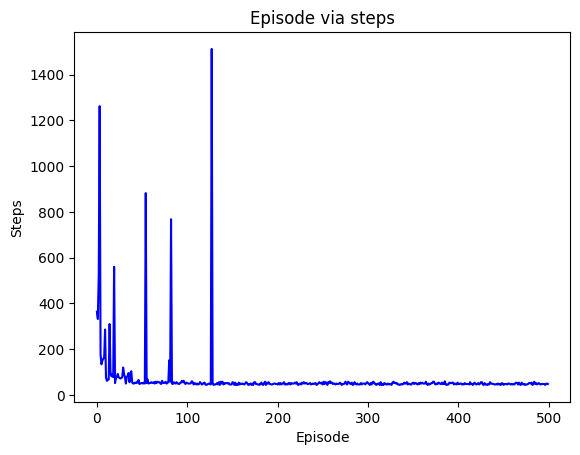

In [47]:
rl.plt_steps()

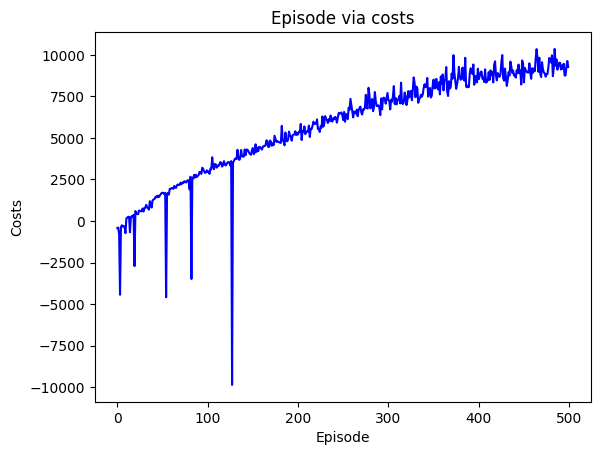

In [48]:
rl.plt_costs()

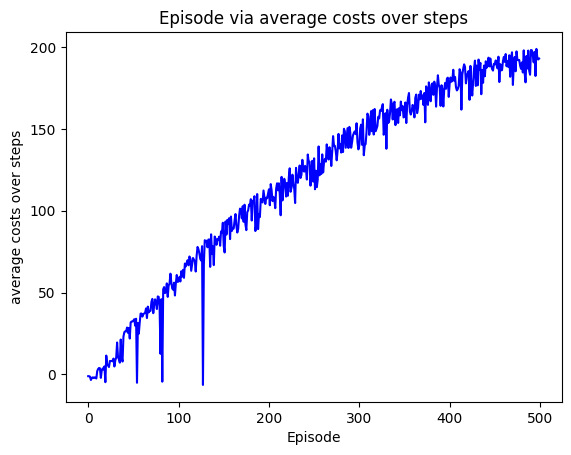

In [49]:
rl.plt_costs_av_steps()

In [50]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",320.364064,NaN,NaN,NaN
1,"(0, 0, (False, True, False, False, False, False))",-2.710000,NaN,NaN,NaN
2,"(0, 0, (True, True, False, False, False, False))",-4.095100,NaN,NaN,NaN
3,"(0, 0, (True, True, True, False, False, False))",-5.695328,NaN,NaN,NaN
4,"(0, 0, (True, True, True, True, True, False))",-9.835768,NaN,NaN,NaN
5,"(0, 2, (False, True, False, False, False, False))",119.157751,NaN,NaN,NaN
6,"(0, 2, (True, False, False, False, False, False))",-1.000000,NaN,-0.100000,NaN
7,"(0, 2, (True, True, False, False, False, False))",-4.312817,NaN,136.825499,NaN
8,"(0, 2, (True, True, True, False, False, False))",-6.513216,NaN,-6.513216,NaN
9,"(0, 2, (True, True, True, True, True, False))",-9.880275,NaN,-9.877991,NaN


In [51]:
rl.play(True, True)

(44, 8765.959186940512)

# Part 6
## (gamma = 1) (alpha = 0.5)

As we know, by increasing the alpha, we will reach a reasonable number of steps faster, so that in the previous episodes, we had to train at least 40-50 times, but here we reached a reasonable result with 10 times the number of training, but a high alpha causes that in a situation that epsilon is inactive, the influence of other houses on the right path increases and we get stuck in a loop and do not get a reasonable result. This is evident in the charts and fluctuations.

In [52]:
doDraw, times, gamma, alpha = False, 500, 1, .5
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 464 with Costs: -2158.75
Done 1| Steps: 440 with Costs: -2571.919921875
Done 2| Steps: 130 with Costs: -197.40625
Done 3| Steps: 356 with Costs: -1885.1785049438477
Done 4| Steps: 120 with Costs: 161.9874906539917
Done 5| Steps: 742 with Costs: -5476.943220287561
Done 6| Steps: 776 with Costs: -6005.163803422431
Done 7| Steps: 1300 with Costs: -11002.129245793023
Done 8| Steps: 82 with Costs: 1115.4178253611676
Done 9| Steps: 88 with Costs: 1344.5301594176287
Done 10| Steps: 56 with Costs: 1655.2631382201073
Done 11| Steps: 72 with Costs: 1739.2106934264957
Done 12| Steps: 56 with Costs: 2132.6351280212402
Done 13| Steps: 98 with Costs: 1716.719111442566
Done 14| Steps: 68 with Costs: 2424.480655670166
Done 15| Steps: 54 with Costs: 2514.9711122512817
Done 16| Steps: 48 with Costs: 2578.1156351566315
Done 17| Steps: 1144 with Costs: -8117.747773851828
Done 18| Steps: 56 with Costs: 2941.2525621652603
Done 19| Steps: 56 with Costs: 3191.788623690605
Done 20| Steps: 52 wit

Done 405| Steps: 54 with Costs: 10793.257375519363
Done 406| Steps: 46 with Costs: 8889.314513541594
Done 407| Steps: 56 with Costs: 11572.060285685686
Done 408| Steps: 52 with Costs: 10068.72597080736
Done 409| Steps: 50 with Costs: 9725.368842429152
Done 410| Steps: 48 with Costs: 9269.295354634121
Done 411| Steps: 48 with Costs: 9200.33913767693
Done 412| Steps: 48 with Costs: 9392.468229231665
Done 413| Steps: 48 with Costs: 9454.936773982425
Done 414| Steps: 52 with Costs: 10144.066899950061
Done 415| Steps: 54 with Costs: 10473.159670640418
Done 416| Steps: 60 with Costs: 11646.231066176673
Done 417| Steps: 52 with Costs: 10344.435408908777
Done 418| Steps: 54 with Costs: 10614.625539363715
Done 419| Steps: 48 with Costs: 9572.863344425183
Done 420| Steps: 54 with Costs: 10823.061475264443
Done 421| Steps: 50 with Costs: 9686.18991141428
Done 422| Steps: 52 with Costs: 10054.52174203559
Done 423| Steps: 56 with Costs: 10797.205433700135
Done 424| Steps: 50 with Costs: 9577.904537

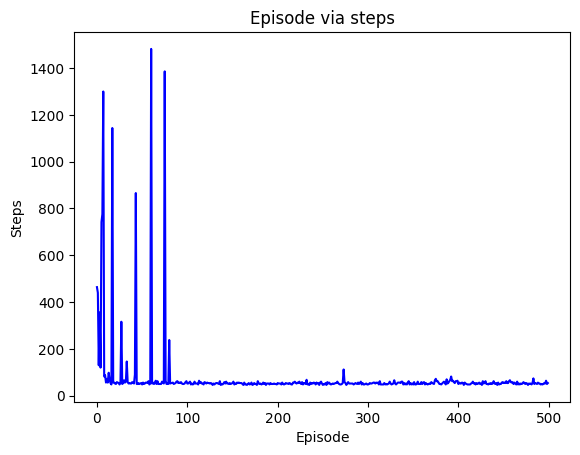

In [53]:
rl.plt_steps()

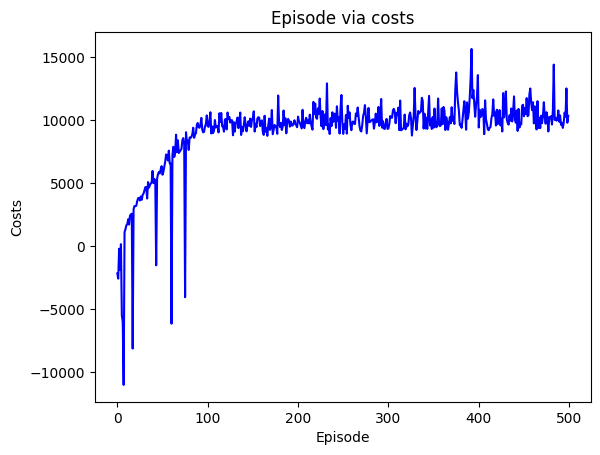

In [54]:
rl.plt_costs()

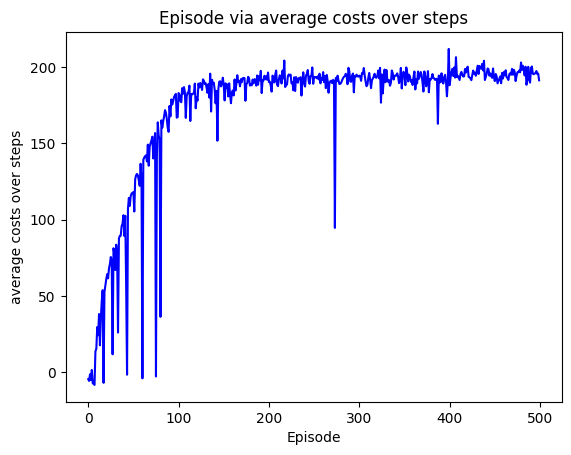

In [55]:
rl.plt_costs_av_steps()

In [58]:
rl.play(True, True)

(66, 12652.454342982486)

# Part 7
## (gamma = 1) (alpha = 0.8)
In this alpha, the result without epsilon is not good and the graphs experience extreme fluctuations, although it is better than the previous alpha because it does not get stuck in the loop and shows a good result most of the time.

But like the previous alpha, in this experiment we got a reasonable answer very quickly because q's are more effective. (which may also cause it to get stuck in a local optimum.)

In [67]:
doDraw, times, gamma, alpha = False, 500, 1, .8
maze = Maze(mazeM, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 1328 with Costs: -11820.4671328257
Done 1| Steps: 474 with Costs: -3553.473652028525
Done 2| Steps: 100 with Costs: 91.11387648819203
Done 3| Steps: 146 with Costs: -14.421119347589112
Done 4| Steps: 72 with Costs: 1055.0744113923665
Done 5| Steps: 80 with Costs: 1314.3808234977055
Done 6| Steps: 194 with Costs: 456.89946295120797
Done 7| Steps: 104 with Costs: 1852.1784053407894
Done 8| Steps: 126 with Costs: 1575.3138936032442
Done 9| Steps: 54 with Costs: 2297.0336619204186
Done 10| Steps: 332 with Costs: 389.7634974176002
Done 11| Steps: 54 with Costs: 2754.458077506502
Done 12| Steps: 48 with Costs: 2891.8613637998537
Done 13| Steps: 54 with Costs: 3215.4475595084023
Done 14| Steps: 64 with Costs: 3547.4051556328295
Done 15| Steps: 56 with Costs: 3863.38358830664
Done 16| Steps: 52 with Costs: 3716.825752072106
Done 17| Steps: 56 with Costs: 3987.6957735513856
Done 18| Steps: 66 with Costs: 4616.0834960094235
Done 19| Steps: 78 with Costs: 4439.797825386489
Done 20|

Done 209| Steps: 50 with Costs: 10201.684443081482
Done 210| Steps: 50 with Costs: 9808.209905361751
Done 211| Steps: 46 with Costs: 9118.032097272247
Done 212| Steps: 52 with Costs: 10326.923300489256
Done 213| Steps: 56 with Costs: 10736.193083519753
Done 214| Steps: 66 with Costs: 11595.818128864861
Done 215| Steps: 62 with Costs: 10755.260339284117
Done 216| Steps: 46 with Costs: 8942.113187088486
Done 217| Steps: 56 with Costs: 11110.98881459701
Done 218| Steps: 48 with Costs: 9789.218028136016
Done 219| Steps: 58 with Costs: 11167.597404572261
Done 220| Steps: 60 with Costs: 11698.204631651151
Done 221| Steps: 52 with Costs: 10353.76300922624
Done 222| Steps: 52 with Costs: 10604.148559663165
Done 223| Steps: 54 with Costs: 10329.298449829885
Done 224| Steps: 56 with Costs: 10556.593881122799
Done 225| Steps: 64 with Costs: 12100.79597583481
Done 226| Steps: 54 with Costs: 10505.69904523917
Done 227| Steps: 58 with Costs: 11303.814771853664
Done 228| Steps: 48 with Costs: 9540.87

Done 483| Steps: 56 with Costs: 9645.220912226823
Done 484| Steps: 54 with Costs: 8973.891931060336
Done 485| Steps: 70 with Costs: 11608.227673197372
Done 486| Steps: 58 with Costs: 10012.37608323661
Done 487| Steps: 64 with Costs: 11451.99943687506
Done 488| Steps: 54 with Costs: 9325.093827226301
Done 489| Steps: 56 with Costs: 9489.20264698209
Done 490| Steps: 52 with Costs: 9184.522767326236
Done 491| Steps: 50 with Costs: 8635.777725793865
Done 492| Steps: 46 with Costs: 8226.415222336367
Done 493| Steps: 46 with Costs: 8384.080786704853
Done 494| Steps: 56 with Costs: 10143.259471742174
Done 495| Steps: 48 with Costs: 8838.841037725455
Done 496| Steps: 60 with Costs: 11192.94695012258
Done 497| Steps: 50 with Costs: 9311.297804243552
Done 498| Steps: 48 with Costs: 8536.72660663929
Done 499| Steps: 48 with Costs: 8930.406094827327
The average of the last 5:  50.8


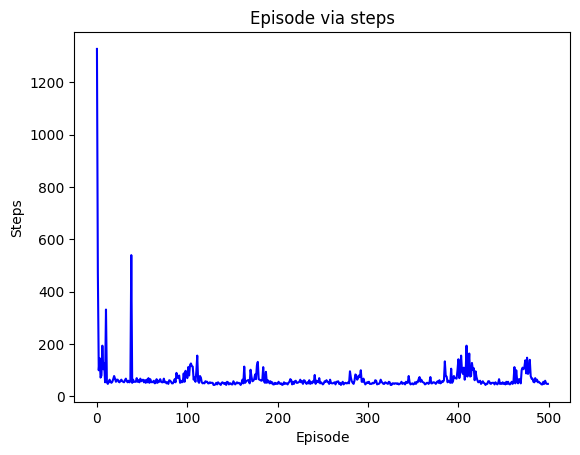

In [68]:
rl.plt_steps()

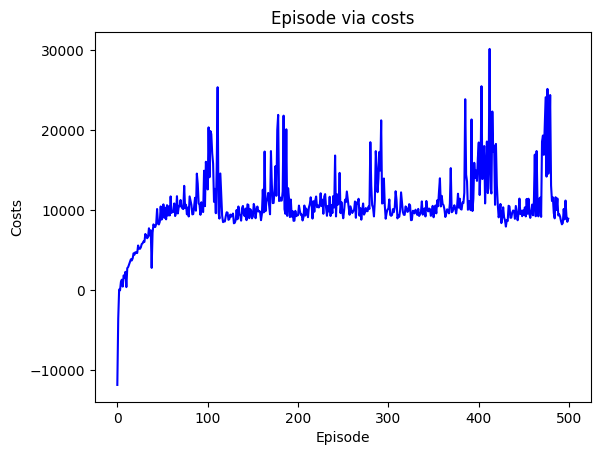

In [69]:
rl.plt_costs()

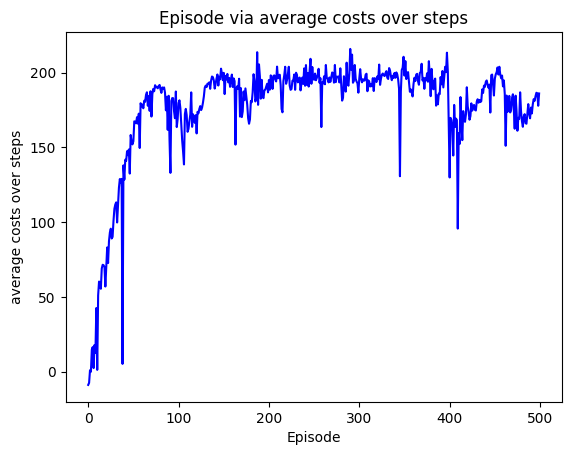

In [70]:
rl.plt_costs_av_steps()

In [72]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, False, False, False, False, Fal...",265.250837,NaN,NaN,NaN
1,"(0, 0, (False, True, False, False, False, False))",258.198827,NaN,NaN,NaN
2,"(0, 0, (True, True, False, False, False, False))",-9.999999,NaN,NaN,NaN
3,"(0, 0, (True, True, True, True, False, False))",-9.999872,NaN,NaN,NaN
4,"(0, 0, (True, True, True, True, True, False))",-8.000000,NaN,NaN,NaN
5,"(0, 2, (False, True, False, False, False, False))",189.427891,NaN,173.788889,NaN
6,"(0, 2, (True, False, False, False, False, False))",-9.600000,NaN,-8.000000,NaN
7,"(0, 2, (True, True, False, False, False, False))",146.999596,NaN,144.343749,NaN
8,"(0, 2, (True, True, True, False, False, False))",-9.600000,NaN,-9.600000,NaN
9,"(0, 2, (True, True, True, True, False, False))",-9.999360,NaN,-9.999974,NaN


In [71]:
rl.play(True, True)

(46, 8813.208853511645)

In [66]:
rl.play(True, True)

(44, 8786.057815129067)

# Part 8

## Test other Maze

In [84]:
mazeB = [
    [0, 0, 4, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 0, 1, 1, 1, 0],
    [0, 4, 1, 4, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
    [0, 0, 3, 1, 0, 0, 1, 1, 1, 1]]

In [85]:
doDraw, times, gamma, alpha = False, 500, .9, .1
maze = Maze(mazeB, doDraw)
rl = RL(maze, times, gamma, alpha)
rl.start()
if doDraw:
    pg.quit()

Done 0| Steps: 114 with Costs: -125.58000000000008
Done 1| Steps: 134 with Costs: -172.2436999999999
Done 2| Steps: 286 with Costs: -278.0585000000003
Done 3| Steps: 58 with Costs: -78.90034000000003
Done 4| Steps: 486 with Costs: -738.7364169999985
Done 5| Steps: 248 with Costs: -470.3582842999996
Done 6| Steps: 330 with Costs: -678.0141452699995
Done 7| Steps: 362 with Costs: -720.5125699739984
Done 8| Steps: 838 with Costs: -2053.3949843456107
Done 9| Steps: 230 with Costs: -262.2711268327191
Done 10| Steps: 90 with Costs: -144.16098592776817
Done 11| Steps: 70 with Costs: -104.75461513399128
Done 12| Steps: 426 with Costs: -1442.826349753892
Done 13| Steps: 690 with Costs: -3001.144350596558
Done 14| Steps: 720 with Costs: -4401.185656538743
Done 15| Steps: 340 with Costs: -2034.6256491793959
Done 16| Steps: 1250 with Costs: -9586.045427262625
Done 17| Steps: 366 with Costs: -1003.0660098627102
Done 18| Steps: 66 with Costs: 34.96579323676051
Done 19| Steps: 46 with Costs: 163.5573

Done 245| Steps: 46 with Costs: 1825.9287388119433
Done 246| Steps: 50 with Costs: 1750.8655004205552
Done 247| Steps: 46 with Costs: 1788.8193682995254
Done 248| Steps: 54 with Costs: 1985.7008827188106
Done 249| Steps: 60 with Costs: 1963.3406423694134
Done 250| Steps: 48 with Costs: 1924.992861100322
Done 251| Steps: 50 with Costs: 1897.1252737491566
Done 252| Steps: 50 with Costs: 1947.0900038303978
Done 253| Steps: 56 with Costs: 2044.5724667637028
Done 254| Steps: 54 with Costs: 1902.5025868119162
Done 255| Steps: 50 with Costs: 1824.0149710818112
Done 256| Steps: 46 with Costs: 1829.509992023749
Done 257| Steps: 48 with Costs: 1884.6039592533089
Done 258| Steps: 58 with Costs: 2005.8379145424128
Done 259| Steps: 46 with Costs: 1893.9845530233442
Done 260| Steps: 80 with Costs: 505.2946405842596
Done 261| Steps: 52 with Costs: 1682.186391806608
Done 262| Steps: 48 with Costs: 1897.269836881997
Done 263| Steps: 66 with Costs: 783.914441057662
Done 264| Steps: 50 with Costs: 1982.0

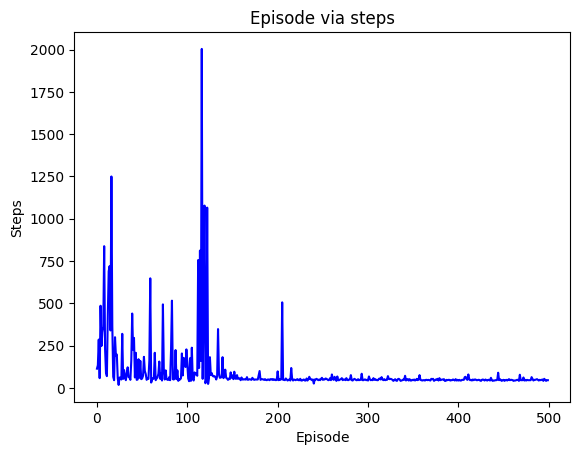

In [86]:
rl.plt_steps()

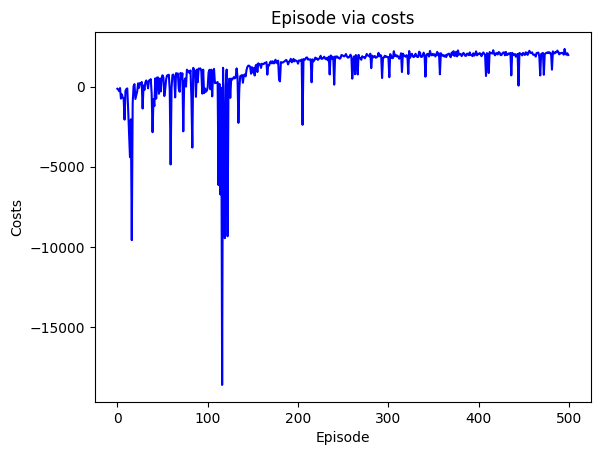

In [87]:
rl.plt_costs()

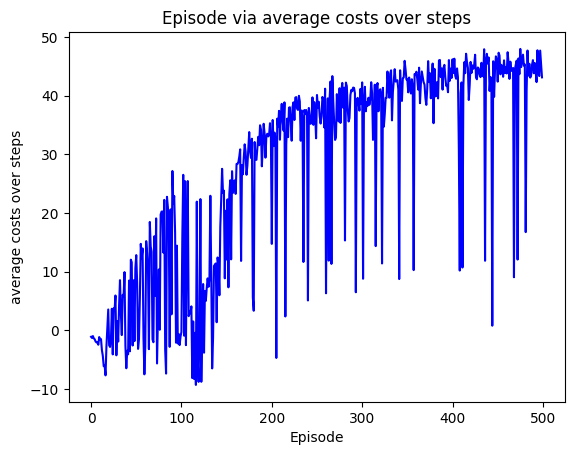

In [88]:
rl.plt_costs_av_steps()

In [90]:
rl.print_Qs_Nan()

Action,State,Down,Left,Right,Up
0,"(0, 0, (False, True, False, True))",-1.000000,NaN,20.890779,NaN
1,"(0, 0, (True, False, False, False))",-3.831931,NaN,-4.095100,NaN
2,"(0, 0, (True, False, True, False))",31.252449,NaN,-2.491425,NaN
3,"(0, 0, (True, False, True, True))",-1.900000,NaN,-1.000000,NaN
4,"(0, 0, (True, True, False, False))",-2.710000,NaN,-2.710000,NaN
5,"(0, 0, (True, True, False, True))",-6.513216,NaN,-6.697408,NaN
6,"(0, 0, (True, True, True, False))",-8.499054,NaN,-6.652919,NaN
7,"(0, 0, (True, True, True, True))",-9.997003,NaN,-9.849350,NaN
8,"(0, 1, (False, True, False, True))",NaN,-0.976600,40.734899,NaN
9,"(0, 1, (True, False, False, False))",3.112684,-3.040588,-4.685590,NaN


In [91]:
rl.play(True, True)

(42, 2005.6264508206866)